# Исследование производительности многошаговой беспроводной сети IEEE 802.11

This experiment consists of a calibration method of queueing model. We consider a tandem model of a wireless network with  𝑀/𝑃𝐻/𝑁/1⟶…⟶./𝑃𝐻/𝑁/1  nodes. The exponential distribution is used to model an arrival distribution. A service time distribution is obtained by PH fitting methods. Approximation of a service time distribution is implemented with Network Simulation 3 NS-3. We researched IEEE 802.11n wireless broadband network.

Queueing model is built with the simulation model of Open Source project in Python `https://github.com/ipu69/pyqumo`.

In [11]:
import json
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import seaborn as sns
from typing import Sequence, Dict
from tabulate import tabulate
import os

from tqdm.notebook import tqdm

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.fitting.acph2 import fit_acph2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, \
    moment as get_moment_of, rel_err
from pyqumo.stats import get_noncentral_m3

from pyqumo.random import HyperErlang, Exponential, Erlang, Distribution
from pyqumo.cqumo.sim import simulate_tandem

from utility.jupyter_helpers import setup_matplotlib, savefig, get_color, \
    set_axes_formatter

# plt.style.use('seaborn-white')
# sns.set_palette('dark')
#sns.set_theme(style="whitegrid")
#sns.set_style("grid", {'legend.frameon':True})

Настроим библиотеки.

In [3]:
# Настраиваем matplotlib
%matplotlib inline
setup_matplotlib()

## Настройка параметров окружения

In [4]:
DATA_DIR = os.path.join("data", "ns3")
NS3_PACKETS_COUNT = 1_000_000

SIM_PACKETS_COUNT = 100_000  # число пакетов для модели массового обслуживания

Вспомогательные методы для загрузки и получения вспомогательных данных.

In [5]:
def load_json_data(file_name: str):
    path = os.path.join(DATA_DIR, file_name)
    return pd.read_json(path).rename(columns={0: "delay"})

def get_bitrate(intensity):
    bitrate = intensity * 1500 * 8 / 1_000_000
    return bitrate

## Загрузка данных из имитационной модели калибровочной сети

Для моделирования беспроводной сети произвольного размера нам нужны 
распределения времени передачи пакетов на четырех каналах: 

```
S1 -- {802.11} --> S2 -- {802.11} --> S3 -- {802.11} --> S4 -- {802.11} -> S5
```

Это связано с тем, что в сети, содержащей пять узлов и четыре канала, эти каналы
испытывают все возможные виды конкуренции:

- канал `S1 --> S2` ожидает, если передачу ведет станция `S2`, и подвержен 
коллизиям со стороны станции `S3`;
- канал `S2 --> S3` ожидает, если передачу ведут станции `S1` или `S3` и 
подвержен коллизиям со стороны станции `S4`;
- канал `S3 --> S4` ожидает, если передачу ведут станции `S2` или `S4`, 
но не подвержен коллизиям, так как станция `S5` не передает данные никому;
- канал `S4 --> S5` ожидает, если передачу ведет станция `S3` и не подвержен
коллизиям.

Если в сети больше станций, дополнительные промежуточные каналы будем 
моделировать как канал `S2 --> S3`.

Прежде, чем перейти к моделированию сетей произвольного размера, загрузим 
данные, полученные из NS-3 для длительностей передачи пакетов в калибровочной
сети. По этим данным построим PH-распределения, найдем оценки межконцевых
задержек с помощью сети массового обслуживания, и сравним результаты с данными
имитационного моделирования беспроводной сети в NS-3.

Беспроводная сеть моделировалась в системе NS-3. Базовые станции были
настроены на работу в режиме ad-hoc и имели следующие настройки:

- протокол IEEE 802.11g;
- размер буфера на MAC-уровне = 500.

На вход первой станции подавался пуассоновский поток. Размер пакетов был
фиксирован и равен `1500` байтам. Для каждой сети моделировалось по `1'000'000`
пакетов. Рассматривались пять разных интенсивностей потока:

- $\lambda = 100$: поток 1.2 мегабит/с
- $\lambda = 200$: поток 2.4 мегабит/с
- $\lambda = 500$: поток 6 мегабит/с
- $\lambda = 750$: поток 9 мегабит/с
- $\lambda = 1000$: поток 12 мегабит/с

Для каждого пакета, который не был потерян из-за переполнения буфера
или слишком большого числа передач, было записано время с первого взятия из
буфера и до успешного получения подтверждения доставки `ACK`. Полученная выборка
была записана в JSON-файлы с именами `5_stations_lambda={rate}_station_{i}.json`,
где `rate = 100, 200, 500, 750, 1000` и `i = 0, 1, 2, 3` по номеру канала.

In [6]:
RATES = [100, 200, 500, 750, 1000]

Так как нам потребуются моменты распределений времени передачи пакетов, сразу
вычислим их при загрузке данных из JSON. Для удобного хранения введем 
вспомогательный класс `Link`.

In [7]:
class Link:
    """
    Хранит выборку длительностей передачи пакетов и вычисленные моменты.
    
    Свойства:
    - rate (float): интенсивность входящего потока
    - link_index (int): номер линка
    - df (DataFrame): фрейм, загруженный из JSON, со столбцом "delay".
    - array (np.ndarray): столбец "delay" в виде np.ndarray
    - mean (float): среднее значение
    - cv (float): коэффициент вариации
    - skew (float): коэффициент асимметрии
    - moments (tuple): первые три нецентральные момента
    """
    def __init__(self, rate: float, link_index: int, df: pd.DataFrame):
        self.rate = rate
        self.link_index = link_index
        self.df = df
        self.array = np.asarray(df["delay"])
        moments = tuple(get_moment_of(self.array, maxn=3))
        self.moments = moments
        self.mean = moments[0]
        self.cv = get_cv(moments[0], moments[1])
        self.skew = get_skewness(*moments)
    
    def to_dict(self):
        return {
            'rate': self.rate,
            'link_index': self.link_index,
            'mean': self.mean,
            'cv': self.cv,
            'skew': self.skew,
        }

Также при загрузке нужно удалить длительности, которые явно являются случайными
выбросами. Таковыми будем считать длительности, превышающие 1.0 секунды -
в реальности пакеты с такой задержкой не будут доставлены и будут отброшены
станцией.

In [8]:
def drop_outliers(df: pd.DataFrame, bound: float = 1.0):
    return df[df.delay <= bound]

Загрузим данные.

In [9]:
def load_calibration_network_links(rates: Sequence[float] = RATES):
    links = {}
    for rate in tqdm(rates):
        links[rate] = []
        for link_index in range(4):
            fname = f"5_stations_lambda={rate}_station_{link_index}.json"
            df = load_json_data(fname)
            original_size = len(df.delay)
            
            # Отфильтровываем выбросы
            df = drop_outliers(df)
            filtered_size = len(df.delay)

            num_outliers = original_size - filtered_size
            if num_outliers > 0:
                print(f"- Rate = {rate}, link #{link_index}: filtered "
                      f"{num_outliers} outliers, {filtered_size} records left.")
            
            # Создаем объект Link
            links[rate].append(Link(link_index=link_index, rate=rate, df=df))
    print(f"Loaded {4 * len(rates)} links records")
    return links

# Загружаем данные.
LINKS = load_calibration_network_links()

  0%|          | 0/5 [00:00<?, ?it/s]

- Rate = 500, link #1: filtered 1 outliers, 999848 records left.
- Rate = 750, link #1: filtered 13 outliers, 860808 records left.
- Rate = 1000, link #3: filtered 84 outliers, 646972 records left.
Loaded 20 links records


Посмотрим на загруженные данные. Во-первых, для средней интенсивности 
$\lambda = 500$ посмотрим, как меняется распределение времени передачи от
номера канала.

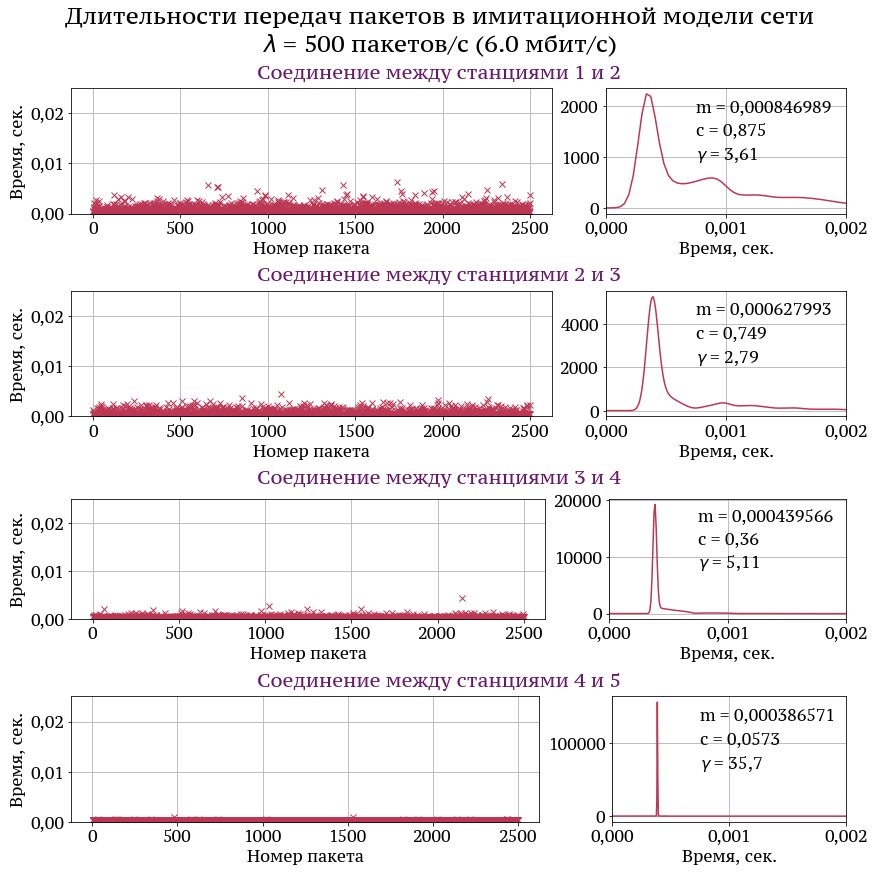

In [13]:
def plot_links_densities(rate: int, image_name: str = ""):
    """
    Нарисовать график с выборкой и эмпирическими плотностями распределения
    для каждого из каналов сети при заданной интенсивности входящего трафика.
    """
    links = LINKS[rate]
    samples = [link.df.sample(250_000) for link in LINKS[rate]]

    fig = plt.figure(figsize=(12, 12), layout='constrained')
    subfigures = fig.subfigures(4, 1, wspace=0.1)
    fig.suptitle("Длительности передач пакетов в имитационной модели сети\n"
                 fr"$\lambda$ = {rate} пакетов/с ({get_bitrate(rate)} мбит/с)",
                 fontsize='x-large')
        
    # Сколько будем рисовать точек на левых графиках.
    sub_sample_size = 2_500
    ox_sample = np.arange(1, sub_sample_size + 1)
    
    # Рисуем графики для каждого линка.
    for i, (subfig, link) in enumerate(zip(subfigures, links)):
        # Так как плотность распределения для миллиона значений строится долго,
        # сделаем случайную выборку меньшего размера.
        df = link.df.sample(100_000)
        
        # Настраиваем графики для линка: слева будет выборка, справа плотность.
        subfig.suptitle(f"Соединение между станциями {i+1} и {i+2}",
                        color=get_color(0.3), fontsize='large')
        ax_sample, ax_density = subfig.subplots(
            1, 2, 
            gridspec_kw={'width_ratios': [2, 1]})
        
        # Рисуем фрагмент выборки слева.
        ax_sample.set_ylim((0, 0.025))
        ax_sample.plot(
            ox_sample, df.sample(sub_sample_size), 'x', 
            color=get_color(0.5))
        ax_sample.grid()
        ax_sample.set_ylabel("Время, сек.")
        ax_sample.set_xlabel("Номер пакета")
        
        # На правом графике строим плотность распределения.
        df.delay.plot.kde(ax=ax_density, color=get_color(0.5))
        ax_density.grid()
        ax_density.set_xlim((0, 0.002))
        ax_density.set_xticks((0, 0.001, 0.002))
        ax_density.set_ylabel('')
        ax_density.set_xlabel("Время, сек.")
        
        # Также на правом графике выведем среднее, коэффициенты вариации и
        # асимметрии.
        max_y = ax_density.get_ylim()[1]
        max_x = ax_density.get_xlim()[1]
        x0 = 1.5 * max_x / 4
        ax_density.text(x0, 4*max_y/5, fr'm = ' + fr'{link.mean:n}')
        ax_density.text(x0, 3*max_y/5, fr'c = ' + f'{link.cv:.3n}')
        ax_density.text(x0, 2*max_y/5, fr'$\gamma$ = ' + f'{link.skew:.3n}')
        
        set_axes_formatter(ax_density, use_y=True)
        set_axes_formatter(ax_sample, use_x=True)

    savefig(image_name)
        
plot_links_densities(rate=500, image_name="ch4_ns3_calibration_links_densities")

Во-вторых, посмотрим, как зависят коэффициенты вариации и асимметрии, а также 
среднее время передачи, от интенсивности входящего потока.

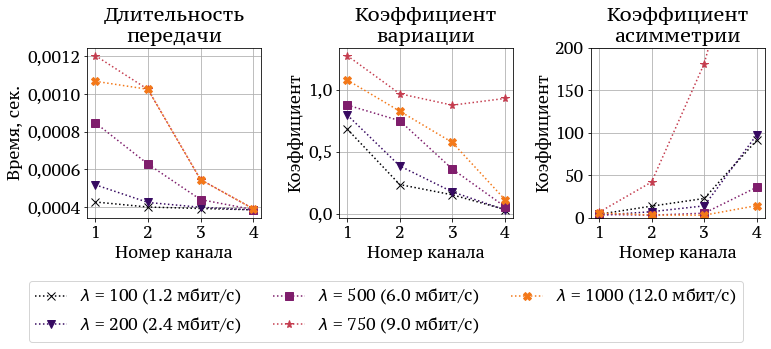

In [15]:
def plot_links_coefs(image_name: str = ""):
    fig, axes = plt.subplots(figsize=(11, 4), ncols=3)
    (ax0, ax1, ax2) = axes

    markers = ['x', 'v', 's', '*', 'X']
    colors = [get_color(i / (len(RATES) - 1) * 0.7) for i in range(len(RATES))]
    
    # Вычислим средние и коэффициенты.
    means = {rate: [link.mean for link in LINKS[rate]] for rate in RATES}
    cvs = {rate: [link.cv for link in LINKS[rate]] for rate in RATES}
    skews = {rate: [link.skew for link in LINKS[rate]] for rate in RATES}
    links_nums = list(range(1, 5))
    
    # На левом графике строим изменение среднего.
    for i, rate in enumerate(RATES):
        ax0.plot(links_nums, means[rate], ':', color=colors[i],
                 marker=markers[i], markersize=8,
                 label=fr"$\lambda$ = {rate} ({get_bitrate(rate)} мбит/с)")
    
    # На среднем графике строим коэффициенты вариации.
    for i, rate in enumerate(RATES):
        ax1.plot(links_nums, cvs[rate], ':', color=colors[i],
                 marker=markers[i], markersize=8)
    
    # На правом графике строим коэффициенты асимметрии.
    for i, rate in enumerate(RATES):
        ax2.plot(links_nums, skews[rate], ':', color=colors[i],
                 marker=markers[i], markersize=8)
    
    # Добавляем легенду и настраиваем графики.
    ax0.set_title("Длительность\nпередачи")
    ax1.set_title("Коэффициент\nвариации")
    ax2.set_title("Коэффициент\nасимметрии")
    for ax in axes:
        ax.grid()
        ax.set_xlabel("Номер канала")
        ax.set_xticks(links_nums)

    ax0.set_ylabel("Время, сек.")
    for ax in axes[1:]:
        ax.set_ylabel("Коэффициент")
    
    ax2.set_ylim((0, 200))
    
    fig.legend(*ax0.get_legend_handles_labels(), loc="lower center",
               bbox_to_anchor=(0.5, -0.25), ncol=3)
    
    plt.tight_layout()
    savefig(image_name)

plot_links_coefs(image_name="ch4_ns3_calibration_links_koefs")

## Построение PH-распределений времени обслуживания

Для каждого канала калибровочной сети построим PH-распределение, используя
метод поиска PH-распределения по трем моментам, описанный в работе [1].

Кроме того, попробуем использовать самый простейший подход - моделировать
время передачи с помощью экспоненциального распределения (его тоже можно
рассматривать как частный случай PH)

*[1] Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase 
distributions: Mixtures of erlang distributions of common order, Communications 
in Statistics. Stochastic Models, 5:4, 711-743, DOI: 10.1080/15326348908807131*

In [16]:
def fit_links():
    phs = {}
    exps = {}
    for rate in tqdm(RATES):
        phs[rate] = []
        exps[rate] = []
        for link in LINKS[rate]:
            ph, _ = fit_mern2(link.moments)
            phs[rate].append(ph)
            exps[rate].append(Exponential(1 / link.mean))
    return phs, exps

PHS, EXPS = fit_links()

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
ARRIVALS = {rate: Exponential(rate) for rate in RATES}

## Моделирование калибровочной сети

In [18]:
def run_sim(
        rate: int,
        services: Sequence[Distribution], 
        queue_capacity: int = 500
) -> float:
    """
    Выполнить имитационную модель тандема M/M/1.
    
    Args:
        rate (int): интенсивность входа
        services (list of Distribution): распределения времени обслуживания
        queue_capacity (int or np.inf): емкость очереди
    
    Returns:
        delay: межконцевая задержка
    """
    arrival = Exponential(rate)
    ret = simulate_tandem(
        arrival=arrival, 
        services=services, 
        queue_capacity=queue_capacity, 
        max_packets=SIM_PACKETS_COUNT
    )
    return ret.delivery_delays[0].avg

In [19]:
print("Simulating 5-nodes network with M/M/1/N tandem")
CALIB_EXP_DELAYS = {rate: run_sim(rate, EXPS[rate], 500) for rate in tqdm(RATES)}
print("Simulating 5-nodes network with M/PH/1/N tandem")
CALIB_PH_DELAYS = {rate: run_sim(rate, PHS[rate], 500) for rate in tqdm(RATES)}

print("M/M/1/N : ", CALIB_EXP_DELAYS)
print("M/PH/1/N: ", CALIB_PH_DELAYS) 

Simulating 5-nodes network with M/M/1/N tandem


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating 5-nodes network with M/PH/1/N tandem


  0%|          | 0/5 [00:00<?, ?it/s]

M/M/1/N :  {100: 0.0016685359460949605, 200: 0.0018939400233430618, 500: 0.003450171782483345, 750: 0.01743109363114808, 1000: 0.5212601502382417}
M/PH/1/N:  {100: 0.0016263040706247275, 200: 0.0017960967100656559, 500: 0.0030587164472132204, 750: 0.023238739175772603, 1000: 0.5133791323362705}


In [20]:
def load_calib_e2e_delays(rate):
    fname = f"lambda{rate}.json"
    with open(os.path.join(DATA_DIR, fname)) as f:
        data = json.load(f)
    values = []
    for record in data:
        values.append(record['e2e'])
    return np.asarray(values).mean()

CALIB_NS3_DELAYS = {rate: load_calib_e2e_delays(rate) for rate in RATES}
print(CALIB_NS3_DELAYS)

{100: 0.0015305929999999998, 200: 0.00183351, 500: 0.004032088, 750: 0.48787699999999995, 1000: 0.5179347100000001}


/home/andrey/workspace/thesis-queues/experiments/utility/jupyter_helpers.py:70: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from current font.
  plt.savefig(file_path, bbox_inches="tight")
/home/andrey/workspace/thesis-queues/experiments/utility/jupyter_helpers.py:70: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from current font.
  plt.savefig(file_path, bbox_inches="tight")
/home/andrey/workspace/thesis-queues/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


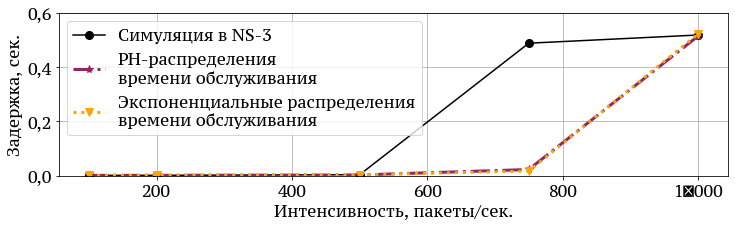

In [21]:
def plot_calib_delays(image_name: str = ""):
    fig, ax = plt.subplots(figsize=(12, 3), nrows=1, ncols=1)
    colors = [get_color(0), get_color(0.4), get_color(0.8)]
    
    y_ns3 = [CALIB_NS3_DELAYS[rate] for rate in RATES]
    y_mm1 = [CALIB_EXP_DELAYS[rate] for rate in RATES]
    y_ph1 = [CALIB_PH_DELAYS[rate] for rate in RATES]
    
    ax.plot(RATES, y_ns3, '-', color=get_color(0), marker='o', markersize=8, 
            label="Симуляция в NS-3")
    ax.plot(RATES, y_ph1, '-.', color=get_color(0.4), marker='*', markersize=8,
            label="PH-распределения\nвремени обслуживания", linewidth=3)
    ax.plot(RATES, y_mm1, ':', color=get_color(0.8), marker='v', markersize=8,
            label="Экспоненциальные распределения\nвремени обслуживания", linewidth=3)
    ax.set_xlabel("Интенсивность, пакеты/сек.")
    ax.set_ylabel("Задержка, сек.")
    
    ax.grid()
    ax.set_ylim((0, 0.6))
    ax.legend()
    savefig(image_name)
    
plot_calib_delays("ch4_ns3_calibration_delays")

In [22]:
def print_table_calib_delays():
    def get_std_err(x, y):
        ay = abs(y)
        return abs(x / (1 + ay)) if ay < 1e-5 else abs((x - y) / y)
        
    heading = ("Rate", "Exp err., %", "PH err., %")
    rows = []
    for rate in RATES:
        x_ns3 = CALIB_NS3_DELAYS[rate]
        x_mm1 = CALIB_EXP_DELAYS[rate]
        x_ph1 = CALIB_PH_DELAYS[rate]
        
        err_mm1 = get_std_err(x_mm1, x_ns3) * 100
        err_ph1 = get_std_err(x_ph1, x_ns3) * 100
        
        rows.append((rate, f'{err_mm1:.3n}', f'{err_ph1:.3n}'))
    print(tabulate(rows, heading))

print_table_calib_delays()

  Rate  Exp err., %    PH err., %
------  -------------  ------------
   100  9,01           6,25
   200  3,3            2,04
   500  14,4           24,1
   750  96,4           95,2
  1000  0,642          0,88


## Моделирование сети произвольного размера

In [28]:
def load_ns3_tandems_end2end_delays():
    delays = {}
    for rate in RATES:
        fname = f"lambda{rate}_stations_count.json"
        with open(os.path.join(DATA_DIR, fname)) as f:
            data = json.load(f)
        delays[rate] = {item["count"]: item["e2e"] for item in data}
    return delays

TANDEM_NS3_DELAYS = load_ns3_tandems_end2end_delays()

# Изобразим все данные в виде таблицы, чтобы было удобнее:
def draw_tandem_delays_table(data):
    rows = []
    all_num_stations = {
        rate: list(data[rate].keys())
        for rate in RATES
    }
    min_num_stations = min([min(ns) for ns in all_num_stations.values()])
    max_num_stations = max([max(ns) for ns in all_num_stations.values()])
    for ns in range(min_num_stations, max_num_stations+1):
        row = (ns, *(data[rate][ns] for rate in RATES))
        rows.append(row)
    print(tabulate(rows, ("Net size", *RATES)))

draw_tandem_delays_table(TANDEM_NS3_DELAYS)

  Net size     100     200     500    750    1000
----------  ------  ------  ------  -----  ------
         4  0.0012  0.0014  0.0024  0.44    0.48
         5  0.0014  0.0016  0.0038  0.451   0.508
         6  0.0018  0.0019  0.0046  0.455   0.511
         7  0.0021  0.0023  0.0052  0.468   0.513
         8  0.0024  0.0026  0.0055  0.471   0.518
         9  0.0028  0.003   0.0062  0.478   0.521
        10  0.003   0.0033  0.0065  0.482   0.523


In [29]:
NET_SIZES = list(range(4, 11))

In [30]:
def get_tandem_services(
        calib: Sequence[Distribution], 
        net_size: int
) -> Sequence[Distribution]:
    """
    Построить набор распределений для сети заданного размера по
    заданным калибровочным распределениям (четырем)
    """
    if net_size <= 1:
        raise ValueError(f"Network size must be >= 2")
    if net_size == 2:
        return (calib[3],)
    if net_size == 3:
        return (calib[2], calib[3])
    return (calib[0],) + (calib[1],) * (net_size - 4) + (calib[2], calib[3])

In [26]:
TANDEM_EXP_DELAYS = {
    rate: {
        net_size: run_sim(rate, get_tandem_services(EXPS[rate], net_size), 500)
        for net_size in NET_SIZES
    }
    for rate in tqdm(RATES)
}
draw_tandem_delays_table(TANDEM_EXP_DELAYS)

  0%|          | 0/5 [00:00<?, ?it/s]

{100: {4: 0.0012556711439477147, 5: 0.0016684884645319137, 6: 0.0020884773894065266, 7: 0.002500288297856322, 8: 0.0029226547708949163, 9: 0.003337579583123133, 10: 0.0037493579428769614}, 200: {4: 0.0014244015499304135, 5: 0.0018955034468291286, 6: 0.0023605534305733097, 7: 0.002826254470784601, 8: 0.0032851219524106584, 9: 0.003742503854520242, 10: 0.004213082448868858}, 500: {4: 0.0025188172856203143, 5: 0.0034345268180592794, 6: 0.004349822468069491, 7: 0.005255298796057378, 8: 0.006176450286430357, 9: 0.007084315011369759, 10: 0.007982363933853555}, 750: {4: 0.014224490597440492, 5: 0.01780263499533433, 6: 0.02101499891462018, 7: 0.027631234547439834, 8: 0.033525029415307724, 9: 0.03416618460270785, 10: 0.04010793648230768}, 1000: {4: 0.5029124560233885, 5: 0.5326318134571927, 6: 0.5504622948079063, 7: 0.5921332123136017, 8: 0.5956753424635735, 9: 0.6222655940613365, 10: 0.6603582440457854}}


In [32]:
TANDEM_PH_DELAYS = {
    rate: {
        net_size: run_sim(rate, get_tandem_services(PHS[rate], net_size), 500)
        for net_size in NET_SIZES
    }
    for rate in tqdm(RATES)
}
draw_tandem_delays_table(TANDEM_PH_DELAYS)

  0%|          | 0/5 [00:00<?, ?it/s]

  Net size         100         200         500        750      1000
----------  ----------  ----------  ----------  ---------  --------
         4  0.00122311  0.00136333  0.00225998  0.0157429  0.494776
         5  0.00162488  0.00180037  0.00303136  0.020859   0.518981
         6  0.00202706  0.00222989  0.00386726  0.0255561  0.537998
         7  0.00242918  0.00266223  0.0046622   0.030375   0.539144
         8  0.00283072  0.00309687  0.00546319  0.0318726  0.574149
         9  0.00323374  0.00352732  0.00624976  0.0372931  0.620386
        10  0.00363204  0.00395612  0.00705195  0.0411334  0.622381


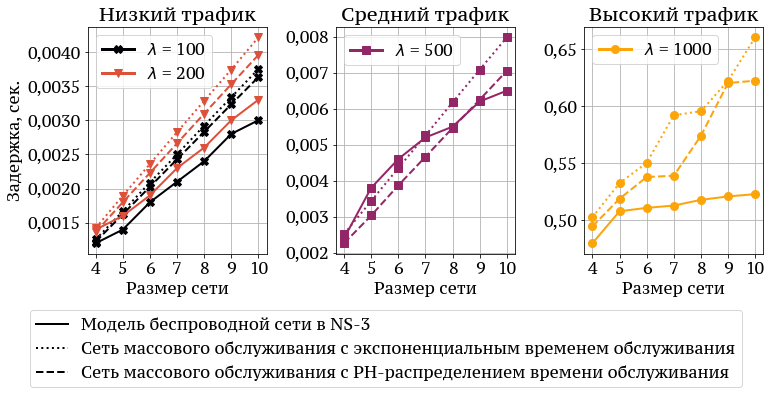

In [171]:
def plot_tandem_delays(
        ns3_delays: Dict[int, Dict[int, float]] = TANDEM_NS3_DELAYS,
        exp_delays: Dict[int, Dict[int, float]] = TANDEM_EXP_DELAYS,
        ph_delays: Dict[int, Dict[int, float]] = TANDEM_PH_DELAYS,
        image_name: str = ""
):
    fig, axes = plt.subplots(figsize=(11, 4.5), ncols=3)
    
    markers = ['X', 'v', 's', '*', 'o']
    colors = [get_color(0), get_color(0.6), get_color(0.4), get_color(0.2), 
              get_color(0.8)]
    
    LOW_RATES = RATES[:2]
    MED_RATES = RATES[2:3]
    HIGH_RATES = RATES[4:]
    
    label_exp = f"экспоненциальное обслуживание"
    label_ph = f"PH-распределения обслуживания"
    
    for rates, ax in zip((LOW_RATES, MED_RATES, HIGH_RATES), axes):
        for rate in rates:
            rate_index = RATES.index(rate)
            y_ns3 = [ns3_delays[rate][ns] for ns in NET_SIZES]
            y_exp = [exp_delays[rate][ns] for ns in NET_SIZES]
            y_ph = [ph_delays[rate][ns] for ns in NET_SIZES]

            marker = markers[rate_index]
            color = colors[rate_index]
            
            label_prefix = fr"$\lambda$ = {rate}"

            ax.plot(NET_SIZES, y_ns3, '-', marker=marker, markersize=8, 
                    color=color, linewidth=2)
            ax.plot(NET_SIZES, y_exp, ':', marker=marker, markersize=8, 
                    color=color, linewidth=2)
            ax.plot(NET_SIZES, y_ph, '--', marker=marker, markersize=8, 
                    color=color, linewidth=2)
        
        # Добавляем линии с маркерами к легенде
        legend_lines = []
        for rate in rates:
            rate_index = RATES.index(rate)
            line = Line2D([0], [0], color=colors[rate_index],
                          marker=markers[rate_index], markersize=8, linewidth=3)
            legend_lines.append(line)
        legend_labels = [fr"$\lambda$ = {rate}" for rate in rates]
        ax.legend(legend_lines, legend_labels)
    
    axes[0].set_ylabel("Задержка, сек.")
    for ax in axes:
        ax.grid()
        ax.set_xlabel("Размер сети")
        ax.set_xticks(NET_SIZES)
    axes[0].set_title("Низкий трафик")
    axes[1].set_title("Средний трафик")
    axes[2].set_title("Высокий трафик")
    
    # Собираем общую легенду. Тут надо расшифровать смысл пунктиров.
    color = get_color(0)
    legend_lines = [
        Line2D([0], [0], linestyle='-', linewidth=2, color=color),
        Line2D([0], [0], linestyle=':', linewidth=2, color=color),
        Line2D([0], [0], linestyle='--', linewidth=2, color=color),
    ]
    legend_labels = [
        "Модель беспроводной сети в NS-3",
        "Сеть массового обслуживания с экспоненциальным временем обслуживания",
        "Сеть массового обслуживания с PH-распределением времени обслуживания",
    ]    
    fig.legend(legend_lines, legend_labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.25), ncol=1)
    
    plt.tight_layout()
    savefig(image_name)

plot_tandem_delays(image_name="ch4_ns3_tandem_delays")

## Анализ изменения потоков в каналах

Для того, чтобы понять, почему пограшность возрастает с увеличением длины сети,
рассмотрим, как меняется длительность обслуживания, вероятности потерь и
пропускная способность каналов.

Промоделируем беспроводную сеть из десяти станций в NS-3 и построим графики
зависимости среднего времени обслуживания и вероятности потери пакета от
номера канала.

Сначала загрузим данные о задержках в каналах сети, состоящей из 10 узлов.
Эти данные записаны в наборе JSON-файлов.

In [80]:
def load_response_times(net_size: int = 10):
    num_channels = net_size - 1
    
    def get_mean_response_time(rate: int, link_index: int):
        fname = f"{net_size}_stations_lambda={rate}_station_{link_index}.json"
        with open(os.path.join(DATA_DIR, str(rate), fname)) as f:
            data = json.load(f)
        return np.mean(data)
    
    return {
        rate_: [get_mean_response_time(rate_, i) for i in range(num_channels)]
        for rate_ in RATES
    }

NET_10_RESPONSE_TIMES = load_response_times()

# Изобразим в виде таблицы
def draw_net_chan_props_table(data, net_size: int = 10):
    rows = []
    for i in range(net_size - 1):
        rows.append([i+1] + [data[rate][i] for rate in RATES])
    print(tabulate(rows, ["Link", *[str(rate) for rate in RATES]]))

draw_net_chan_props_table(NET_10_RESPONSE_TIMES)

  Link          100          200          500          750         1000
------  -----------  -----------  -----------  -----------  -----------
     1  0.000427405  0.000517386  0.000895976  0.00137083   0.00120593
     2  0.000400281  0.000425953  0.000689524  0.00134551   0.00135836
     3  0.000392609  0.000400576  0.000475195  0.000722172  0.00072474
     4  0.000389879  0.00039435   0.000424315  0.000528046  0.000535353
     5  0.00039003   0.000392814  0.000409765  0.000465673  0.000473019
     6  0.000386971  0.0003891    0.000402048  0.000444537  0.000453094
     7  0.000386513  0.000387637  0.000398083  0.000436765  0.000445199
     8  0.00038665   0.000387472  0.000396053  0.000434162  0.000443018
     9  0.000384128  0.000384158  0.000388365  0.00042257   0.000431465


Данные о потерях не были записаны в JSON, вводим их вручную.

In [81]:
NET_10_LOSS_PROBS = {
    100: [0.00417973, 0.00031463, 0.000209776, 0, 0, 0, 0.000104921, 0, 0],
    200: [0.0201415, 0.00178881, 0.000158111, 5.27176e-05, 5.27259e-05, 0, 0, 0, 0],
    500: [0.108786, 0.0315574, 0.00506377, 0.00107588, 0.000211149, 0.000190054, 8.44809e-05, 0, 0],
    750: [0.197842, 0.11093, 0.0344766, 0.00727969, 0.00119327, 0.000128653, 7.35267e-05, 0, 0],
    1000: [0.247207, 0.106394, 0.0336351, 0.00734798, 0.00104589, 0.000238747, 3.67384e-05, 0, 0],
}

draw_net_chan_props_table(NET_10_LOSS_PROBS)

  Link          100          200          500          750         1000
------  -----------  -----------  -----------  -----------  -----------
     1  0.00417973   0.0201415    0.108786     0.197842     0.247207
     2  0.00031463   0.00178881   0.0315574    0.11093      0.106394
     3  0.000209776  0.000158111  0.00506377   0.0344766    0.0336351
     4  0            5.27176e-05  0.00107588   0.00727969   0.00734798
     5  0            5.27259e-05  0.000211149  0.00119327   0.00104589
     6  0            0            0.000190054  0.000128653  0.000238747
     7  0.000104921  0            8.44809e-05  7.35267e-05  3.67384e-05
     8  0            0            0            0            0
     9  0            0            0            0            0


Теперь изобразим задержки в канале и вероятности потерь на графиках.

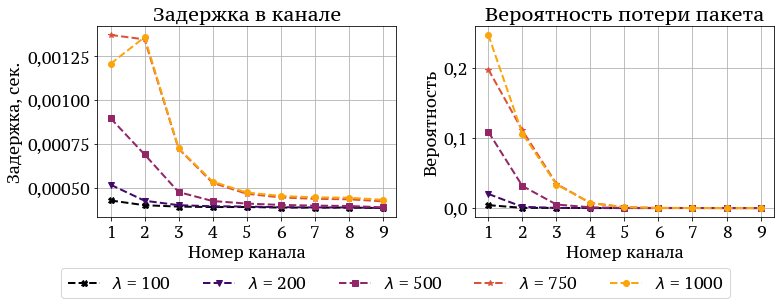

In [97]:
def plot_chan_props(
        net_size: int = 10, 
        response_times: Dict[int, Sequence[float]] = NET_10_RESPONSE_TIMES,
        loss_probs: Dict[int, Sequence[float]] = NET_10_LOSS_PROBS,
        image_name: str = ""
):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    ax0, ax1 = axes
    
    markers = ['X', 'v', 's', '*', 'o']
    colors = [get_color(i / len(RATES)) for i in range(len(RATES))]
    ox = np.arange(1, net_size)
    
    for i, rate in enumerate(RATES):
        kwargs = {
            "color": colors[i],
            "linewidth": 2,
            "marker": markers[i],
            "markersize": 6,
            "label": fr"$\lambda$ = {rate}",
        }
        
        # На левом графике нарисуем задержки в каналах.
        ax0.plot(ox, response_times[rate], '--', **kwargs)

        # На правом графике нарисуем задержки в каналах.
        ax1.plot(ox, loss_probs[rate], '--', **kwargs)
    
    # Настраиваем оси и фон, рисуем легенду.
    for ax in axes:
        ax.grid()
        ax.set_xlabel("Номер канала")
        ax.set_xticks(ox)
        
    ax0.set_title("Задержка в канале")
    ax0.set_ylabel("Задержка, сек.")
    ax1.set_title("Вероятность потери пакета")
    ax1.set_ylabel("Вероятность")
    
    fig.legend(*ax0.get_legend_handles_labels(), loc="lower center",
               bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    plt.tight_layout()
    savefig(image_name)

plot_chan_props(image_name="ch4_ns3_net_10_props")

Можно видеть, что и задержка в каналах, и вероятность потери пакета падает по
мере удаления от источника. Это легко объясняется тем, что на каждую следующую
станцию поступает все более разреженный поток, с которым сеть легче справляется.

Посмотрим, что происходит в сети с пятью станциями. Для этой сети не были
собраны данные по потерям, поэтому ограничимся временем обслуживания.

In [90]:
NET_5_RESPONSE_TIMES = load_response_times(5)

draw_net_chan_props_table(NET_5_RESPONSE_TIMES, 5)

  Link          100          200          500          750         1000
------  -----------  -----------  -----------  -----------  -----------
     1  0.000426254  0.000519149  0.000846296  0.00118274   0.00107083
     2  0.000400055  0.000424415  0.000625945  0.00101551   0.00102242
     3  0.000391902  0.000398708  0.000439397  0.000544356  0.000546544
     4  0.000385223  0.000385353  0.000386609  0.000390817  0.000392693


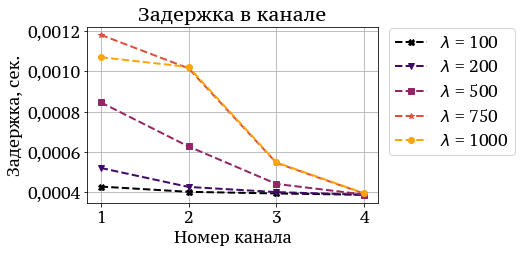

In [112]:
def plot_chan_delays(
        net_size: int = 5, 
        response_times: Dict[int, Sequence[float]] = NET_5_RESPONSE_TIMES, 
        image_name: str = ""
):
    fig, ax = plt.subplots(1, 1, figsize=(9, 3.8))
    
    markers = ['X', 'v', 's', '*', 'o']
    colors = [get_color(i / len(RATES)) for i in range(len(RATES))]
    ox = np.arange(1, net_size)
    
    for i, rate in enumerate(RATES):
        kwargs = {
            "color": colors[i],
            "linewidth": 2,
            "marker": markers[i],
            "markersize": 6,
            "label": fr"$\lambda$ = {rate}",
        }        
        ax.plot(ox, response_times[rate], '--', **kwargs)
    
    # Настраиваем оси и фон, рисуем легенду.
    ax.grid()
    ax.set_xlabel("Номер канала")
    ax.set_ylabel("Задержка, сек.")
    ax.set_xticks(ox)  
    ax.set_title("Задержка в канале")

    plt.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.5, 0.63))
    # ax.legend()
    
    plt.tight_layout()
    savefig(image_name)

plot_chan_delays(image_name="ch4_ns3_net_5_response_times")

Последний график показывает, что задержки в сети из пяти станций меняются
также, как и в сети из десяти станций. Значит, пропускная способность канала
в большей степени определяется тем, какая доля потока была отсеяна до него,
а не тем, с какими соседями он интерферирует.

## Моделирование сети произвольного размера: уточненная методика

Для того, чтобы учесть этот эффект, можно немного изменить методологию: вместо
того, чтобы моделировать промежуточные каналы также, как канал `S2 --> S3`,
буедм моделировать первые три канала как, соответственно, `S1 --> S2`, 
`S2 --> S3` и `S3 --> S4`, а все последующие - как канал `S4 --> S5`.

In [128]:
def get_tandem_services_refined(
        calib: Sequence[Distribution], 
        net_size: int
) -> Sequence[Distribution]:
    """
    Построить набор распределений для сети заданного размера по
    заданным калибровочным распределениям (четырем).
    
    Учитываем данные, полученные из модели сети с 10 узлами, и моделируем
    отдельно первые четыре канала, а все последующие - как четвертый.
    """
    if net_size <= 1:
        raise ValueError(f"Network size must be >= 2")
    if net_size <= 3:
        return calib[:net_size-1]
    return calib[:3] + [calib[3]] * (net_size - 4)

In [129]:
TANDEM_REFINED_EXP_DELAYS = {
    rate: {
        net_size: run_sim(
            rate, get_tandem_services_refined(EXPS[rate], net_size), 500)
        for net_size in NET_SIZES
    }
    for rate in tqdm(RATES)
}
draw_tandem_delays_table(TANDEM_REFINED_EXP_DELAYS)

  0%|          | 0/5 [00:00<?, ?it/s]

  Net size         100         200         500        750      1000
----------  ----------  ----------  ----------  ---------  --------
         4  0.00126778  0.00146662  0.00293246  0.0172024  0.53
         5  0.00167372  0.00188835  0.00343129  0.0175984  0.522439
         6  0.00206987  0.00231265  0.00390633  0.0185227  0.521091
         7  0.00247648  0.00272257  0.00437651  0.0194066  0.52308
         8  0.00287428  0.00315594  0.00485103  0.0210101  0.529088
         9  0.00327561  0.00356199  0.00533808  0.0213126  0.529977
        10  0.00367939  0.00397207  0.0058065   0.0221752  0.533557


In [131]:
TANDEM_REFINED_PH_DELAYS = {
    rate: {
        net_size: run_sim(
            rate, get_tandem_services_refined(PHS[rate], net_size), 500)
        for net_size in NET_SIZES
    }
    for rate in tqdm(RATES)
}
draw_tandem_delays_table(TANDEM_REFINED_PH_DELAYS)

  0%|          | 0/5 [00:00<?, ?it/s]

  Net size         100         200         500        750      1000
----------  ----------  ----------  ----------  ---------  --------
         4  0.00123918  0.00140922  0.00267769  0.0210893  0.531705
         5  0.00162414  0.00179942  0.00304472  0.0260274  0.52207
         6  0.00200941  0.00218426  0.00344086  0.022155   0.527864
         7  0.00239315  0.00256865  0.00383898  0.0218976  0.522489
         8  0.00278004  0.00295565  0.00422611  0.0222481  0.511759
         9  0.00316645  0.00333648  0.00458744  0.0230045  0.522921
        10  0.00355148  0.00372421  0.00499497  0.0228282  0.531441


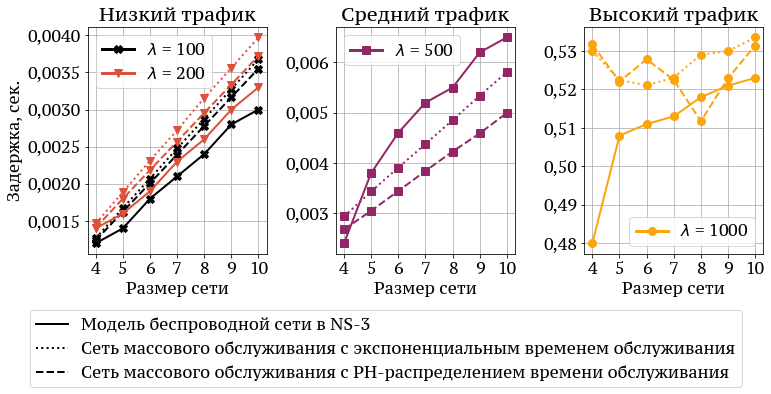

In [172]:
plot_tandem_delays(
    ns3_delays=TANDEM_NS3_DELAYS,
    exp_delays=TANDEM_REFINED_EXP_DELAYS,
    ph_delays=TANDEM_REFINED_PH_DELAYS,
    image_name="ch4_ns3_tandem_delays_refined"
)

Для низкого и очень высокого трафика ошибки стали ниже. Немного неожиданно,
но для среднего трафика ошибка стала даже немного больше, особенно в случае
PH-распределения - в этом случае экспоненциальное распределение показало даже
лучший результат.

In [134]:
def get_errors(
        precise: Sequence[float], 
        approx: Sequence[float]
) -> Sequence[float]:
    """
    Вычислить относительные ошибки для вектора approx относительно precise.
    """
    return [rel_err(p, a) for (p, a) in zip(precise, approx)]

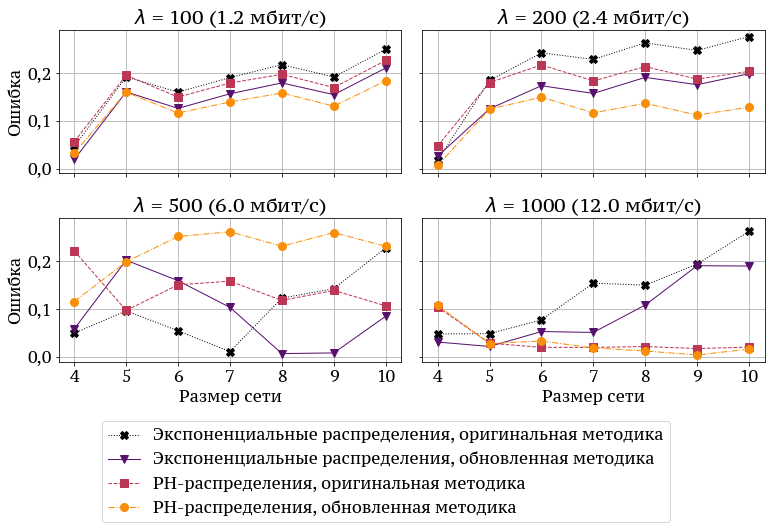

In [173]:
def plot_tandem_delays_errors(image_name: str = ""):
    fig, axes_grid = plt.subplots(2, 2, figsize=(11, 6), 
                                  sharex=True, sharey=True)
    axes = []
    for axes_row in axes_grid:
        axes.extend(axes_row)
    
    markers = ['X', 'v', 's', 'o', '*']
    colors = [get_color(i / 4) for i in range(4)]
    ox = NET_SIZES
    
    for i, (ax, rate) in enumerate(zip(axes, [100, 200, 500, 1000])):
        kwargs = {
            "linewidth": 1,
            "markersize": 8,
        }
        
        ns3_delays = [TANDEM_NS3_DELAYS[rate][i] for i in NET_SIZES]
        exp_delays = [
            [TANDEM_EXP_DELAYS[rate][i] for i in NET_SIZES],
            [TANDEM_REFINED_EXP_DELAYS[rate][i] for i in NET_SIZES]]
        ph_delays = [
            [TANDEM_PH_DELAYS[rate][i] for i in NET_SIZES],
            [TANDEM_REFINED_PH_DELAYS[rate][i] for i in NET_SIZES]]

        exp_err = get_errors(ns3_delays, exp_delays[0])
        ph_err = get_errors(ns3_delays, ph_delays[0])
        exp_refined_err = get_errors(ns3_delays, exp_delays[1])
        ph_refined_err = get_errors(ns3_delays, ph_delays[1])
        
        ax.plot(ox, exp_err, ':', color=colors[0], marker=markers[0], **kwargs,
                label=f"Экспоненциальные распределения, оригинальная методика")
        ax.plot(ox, ph_err, '-', color=colors[1], marker=markers[1], **kwargs,
                label=f"Экспоненциальные распределения, обновленная методика")
        ax.plot(ox, exp_refined_err, '--', color=colors[2], marker=markers[2],
                **kwargs, label=f"PH-распределения, оригинальная методика")
        ax.plot(ox, ph_refined_err, '-.', color=colors[3], marker=markers[3],
                **kwargs, label=f"PH-распределения, обновленная методика")
        
        # Настраиваем график
        ax.set_title(fr"$\lambda$ = {rate} ({get_bitrate(rate)} мбит/с)")
        ax.grid()
    
    for axes_row in axes_grid:
        axes_row[0].set_ylabel("Ошибка")
    for ax in axes_grid[-1]:
        ax.set_xlabel("Размер сети")
    
    fig.legend(*axes[0].get_legend_handles_labels(), loc="lower center",
               bbox_to_anchor=(0.5, -0.25))
    
    plt.tight_layout()
    savefig(image_name)

plot_tandem_delays_errors("ch4_ns3_tandem_errors")